In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchmetrics.classification import Accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
import cv2
import load_data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import torchvision.models as models

In [2]:
# Setup device-agnocstic code
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = '1' #LocalResponseNorm is not available on Apple MPS / this line still does not fix it so i used google colab

In [3]:
# Load CIFAR10 data
train_data, validation_data = load_data.get_train_valid_loader(data_dir='datasets', augment=False, batch_size=128, random_seed=42)
test_data = load_data.get_test_loader(data_dir='datasets', batch_size=128, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Create ZFNet architecture

class ZFNet(nn.Module):
    def __init__(self, in_channels, classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=96, kernel_size=7, stride=2, padding=1),
            nn.ReLU(),
            nn.LocalResponseNorm(5, alpha=10**-4, beta=0.75, k=2), # 'brightness normalization' to reduce overfitting
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True),  #overlapping pooling  #return the indices for unpooling later
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(5, alpha=10**-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, return_indices=True)
        )
        self.classifier = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=classes),
        )

        self._initialize_weights()

        self.sizes = {}
        self.indices = {}
        self.outputs = {}

    def forward(self, x):
        for i, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, indices = layer(x)
                self.indices[i] = indices
            else:
                x = layer(x)
            self.outputs[i] = x.clone()

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def deconv(self, x, layer):
        if layer >= len(self.features):
            raise ValueError("Layer number out of range")

        for i in range(len(self.features) - 1, len(self.features) - layer - 1, -1):
            if isinstance(self.features[i], nn.MaxPool2d):
                x = nn.functional.max_unpool2d(x, self.indices[i],
                                               kernel_size=self.features[i].kernel_size,
                                               stride=self.features[i].stride,
                                               padding=self.features[i].padding,
                                               output_size=self.outputs[i-1].size())
            elif isinstance(self.features[i], nn.Conv2d):
                x = nn.functional.conv_transpose2d(x, self.features[i].weight,
                                                   stride=self.features[i].stride,
                                                   padding=self.features[i].padding)
            elif isinstance(self.features[i], nn.ReLU):
                x = self.features[i](x)
        return x
    
    def visualize_layers(self, input_image):
        self.input_image = input_image.unsqueeze(0)
        self.eval()
        with torch.no_grad():
            output = self(self.input_image)

        probs = torch.nn.Softmax(dim=-1)(output)
        probability, predicted_class = torch.max(probs, dim=1)
        class_name = str(predicted_class.item())

        fig = plt.figure(figsize=(20,20))

        # Ensure the input image is in the correct format and range
        input_image = input_image.clamp(0, 1)  # If normalized between 0 and 1
        input_image = (input_image * 255).byte()  # Convert to 0-255 range
        input_image = input_image.permute(1, 2, 0)

        # plot original image
        fig.add_subplot(1, 6, 1)
        plt.imshow(input_image.cpu().numpy())  # Adjusting channel format for plotting
        plt.title(f"Class: {class_name}, Probability: {probability.item():.4f}", fontsize=13)
        plt.axis('off')


        # plot deconv visualizations
        for j in range(1,6):
            deconv_output = self.deconv(self.outputs[len(self.features)-1], j)
            deconv_output = deconv_output.squeeze(0).cpu().detach().numpy()

            # Normalize the output
            epsilon = 1e-5  # Small value to avoid division by zero
            deconv_output = (deconv_output - deconv_output.min()) / (deconv_output.max() - deconv_output.min() + epsilon)

            # If the output has more than 3 channels, we'll visualize the first 3
            if deconv_output.shape[0] > 3:
                deconv_output = deconv_output[:3]

            # Ensure we have 3 channels for RGB display
            if deconv_output.shape[0] == 1:
                deconv_output = np.repeat(deconv_output, 3, axis=0)
            elif deconv_output.shape[0] == 2:
                deconv_output = np.pad(deconv_output, ((0, 1), (0, 0), (0, 0)), mode='constant')

            # Transpose to (height, width, channels) for imshow
            deconv_output = np.transpose(deconv_output, (1, 2, 0))

            ax = fig.add_subplot(1, 6, j + 1)
            plt.imshow(deconv_output)
            plt.title(f"Layer {j} Deconv", fontsize=13)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    
    def _initialize_weights(self):
        for i in self.modules():
            if isinstance(i, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(i.weight, mean=0, std=0.01),
                nn.init.constant_(i.bias, 0)


## Model Training

In [6]:
net = ZFNet(in_channels=3, classes=10).to(device=device)
net.load_state_dict(torch.load("ZFNet50.pth"))

<All keys matched successfully>

In [7]:
#define loss function, optimizer and accuracy function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=net.parameters(),
    momentum=0.9,
    lr=0.01
    )
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10) #divide lr by 10 everytime validation loss plateaus
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)


In [8]:
# training step
epochs = 30

torch.manual_seed(42)
for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss = 0
    print(f"Epoch: {epoch}/{epochs}\n-----------------------")
    for i, (images, labels) in tqdm(enumerate(train_data), total=len(train_data), desc="Batches"):
        train_loss = 0
        images = images.to(device)
        labels = labels.to(device)

        #training
        net.train()

        #forward pass
        train_pred = net(images)

        #calculate loss
        train_loss += loss_fn(train_pred, labels)

        #backprop
        optimizer.zero_grad()
        train_loss.backward()

        #gradient descent
        optimizer.step()

    train_loss /= len(train_data)

    #evaluation
    eval_loss, eval_acc = 0, 0
    net.eval()
    with torch.inference_mode():
        for i, (images, labels) in enumerate(validation_data):
            images = images.to(device)
            labels = labels.to(device)
            #forward pass
            eval_logits = net(images)
            eval_pred = eval_logits.argmax(dim=1)

            #calculate loss and accuracy
            eval_loss += loss_fn(eval_logits, labels)
            eval_acc += accuracy_fn(eval_pred, labels)

        eval_loss /= len(validation_data)
        eval_acc /= len(validation_data)
        eval_acc *= 100

    print(f"\nTrain loss: {train_loss:.10f} | Val loss: {eval_loss:.10f}, Val acc: {eval_acc:.2f}%\n")
    scheduler.step(eval_loss)


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000001663 | Val loss: 1.6572932005, Val acc: 77.79%

Epoch: 1/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000002166 | Val loss: 1.7193098068, Val acc: 77.99%

Epoch: 2/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000002080 | Val loss: 1.7937303782, Val acc: 77.40%

Epoch: 3/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000328 | Val loss: 1.7614157200, Val acc: 78.03%

Epoch: 4/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000001513 | Val loss: 1.7944730520, Val acc: 78.11%

Epoch: 5/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000171 | Val loss: 1.8427724838, Val acc: 77.50%

Epoch: 6/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000001428 | Val loss: 1.8103001118, Val acc: 77.79%

Epoch: 7/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000198 | Val loss: 1.8803663254, Val acc: 77.50%

Epoch: 8/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000252 | Val loss: 1.9527024031, Val acc: 77.50%

Epoch: 9/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000431 | Val loss: 1.9342483282, Val acc: 77.50%

Epoch: 10/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000222 | Val loss: 1.9864052534, Val acc: 77.23%

Epoch: 11/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000328 | Val loss: 1.9095308781, Val acc: 77.79%

Epoch: 12/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000407 | Val loss: 1.8807153702, Val acc: 78.09%

Epoch: 13/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000105 | Val loss: 1.9007366896, Val acc: 78.09%

Epoch: 14/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000053 | Val loss: 1.9251116514, Val acc: 77.50%

Epoch: 15/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000269 | Val loss: 1.8993577957, Val acc: 78.09%

Epoch: 16/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000737 | Val loss: 1.8985315561, Val acc: 77.79%

Epoch: 17/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000384 | Val loss: 1.9686113596, Val acc: 77.81%

Epoch: 18/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000944 | Val loss: 1.9128503799, Val acc: 77.81%

Epoch: 19/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000216 | Val loss: 1.9183651209, Val acc: 77.52%

Epoch: 20/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000498 | Val loss: 1.8865112066, Val acc: 78.40%

Epoch: 21/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000350 | Val loss: 1.9455120564, Val acc: 77.81%

Epoch: 22/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000266 | Val loss: 1.9026092291, Val acc: 78.09%

Epoch: 23/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000453 | Val loss: 1.9361342192, Val acc: 78.11%

Epoch: 24/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000733 | Val loss: 1.9862301350, Val acc: 77.21%

Epoch: 25/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000375 | Val loss: 1.9119316339, Val acc: 78.09%

Epoch: 26/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000366 | Val loss: 1.9735307693, Val acc: 77.21%

Epoch: 27/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000174 | Val loss: 2.0185964108, Val acc: 77.23%

Epoch: 28/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000406 | Val loss: 1.9277034998, Val acc: 77.81%

Epoch: 29/30
-----------------------


Batches:   0%|          | 0/352 [00:00<?, ?it/s]


Train loss: 0.0000000554 | Val loss: 1.9039335251, Val acc: 77.79%



In [20]:
torch.save(net.state_dict(), f="ZFNet80.pth")

## Load Trained Model and Evaluate Performance

In [6]:
net = ZFNet(in_channels=3, classes=10).to(device=device)
net.load_state_dict(torch.load("ZFNet80.pth"))

<All keys matched successfully>

In [8]:
net.eval()
test_acc = 0
with torch.inference_mode():
    for images, labels in test_data:
        images = images.to(device)
        labels = labels.to(device)
        
        predictions = net(images).argmax(dim=1)
        test_acc += accuracy_fn(predictions, labels)
    test_acc = (test_acc / len(test_data)) *100
    
    print(f"Accuracy of ZFNet on test images: {test_acc:.2f}%")

Accuracy of ZFNet on test images: 77.54%


In [9]:
for images, labels in test_data:
    break  # Get the first batch and break out of the loop

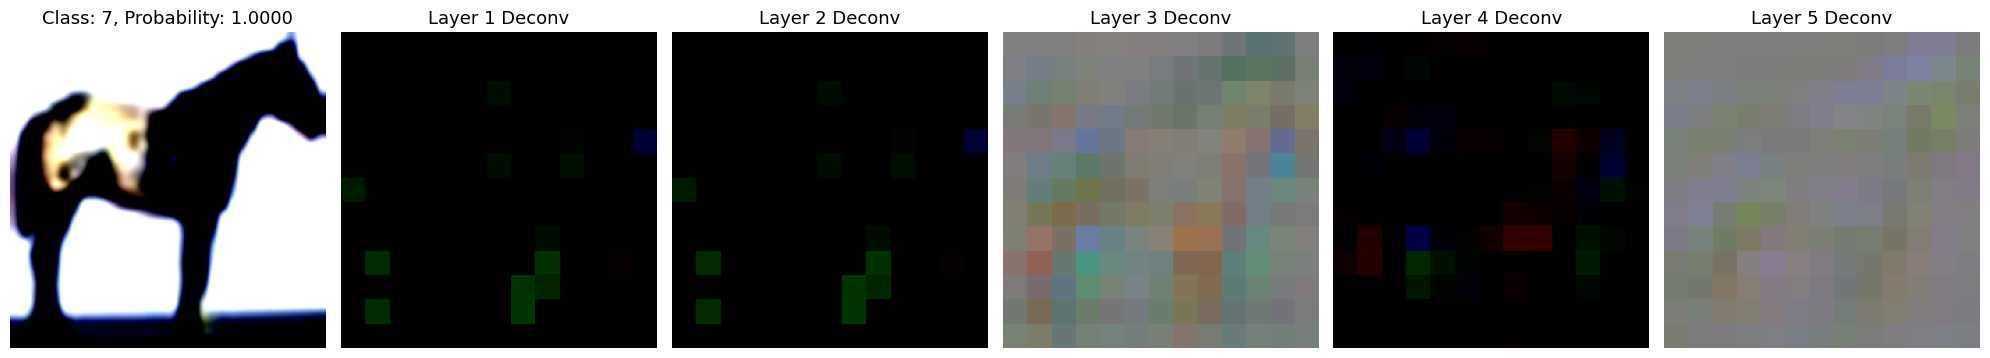

In [22]:
# Step 3: Access the first test image and label
first_image = images[2].to(device)  # Access the first image in the batch

# Perform a forward pass with your input image
net.visualize_layers(first_image)